# **WINE MACHINE LEARNING(UNSUPERVISED)**

### **IMPORTING THE DEPENDENCIES**

In [250]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from joblib import dump
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import v_measure_score

### **DATA COLLECTION**

In [253]:
# Step 1: Load the Wine Dataset (only once)
df_wine = pd.read_csv('wine_label.csv')  # Adjust the path to your dataset

# Show the first few rows of the dataset
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Target
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0


### **Select Data** 

In [256]:
# Step 2: Select only 'alcohol' and 'color_intensity' for clustering
X_wine = df_wine[['alcohol', 'color_intensity']]  # Use only 'alcohol' and 'color_intensity'

# Step 3: Scale the features (used for all clustering models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_wine)

## **Three Training Model**

### ***1. K-Means***

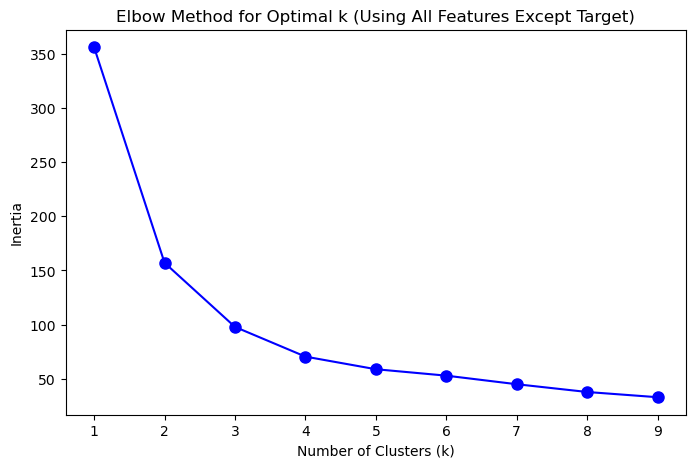

In [189]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")
# Step 4: Apply the Elbow method to determine the optimal number of clusters
inertia = []
K_range = range(1, 10)  # Trying k values from 1 to 9
for k in K_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(X_wine_scaled)  # Fit KMeans on the scaled wine data
    inertia.append(kmeans_test.inertia_)  # Store the inertia for each k

# Step 5: Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (Using All Features Except Target)')
plt.show()

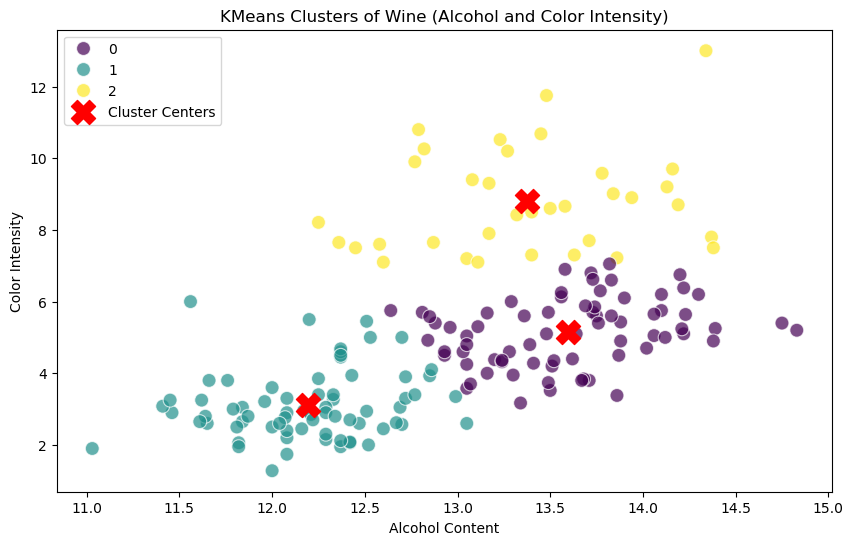

In [260]:
# Step 4: Apply KMeans clustering on the scaled selected features
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster_labels'] = kmeans.fit_predict(X_scaled_selected)

# Step 5: Get the cluster centers for 'alcohol' and 'color_intensity'
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Step 6: Plot the clusters and the centers using 'alcohol' and 'color_intensity' for visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['alcohol'], y=df['color_intensity'], hue=df['cluster_labels'], palette='viridis', s=100, alpha=0.7)

# Plot the cluster centers after inverse transformation (for alcohol and color intensity)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=300, marker='X', label='Cluster Centers')

# Add title and labels
plt.title('KMeans Clusters of Wine (Alcohol and Color Intensity)')
plt.xlabel('Alcohol Content')
plt.ylabel('Color Intensity')
plt.legend()
plt.show()



**Quality of Clustering_K-Means**

In [209]:
# Assuming df['Target'] contains the actual labels (true wine classes)
# Ensure 'Target' is numeric (if it's not already numeric)
df['Target'] = df['Target'].astype(int)  # Convert to integer if necessary

# Calculate the V-measure score between predicted cluster labels and true labels
v_measure = v_measure_score(df['Target'], df['cluster_labels'])

# Output the V-measure score
print(f'V-measure score: {v_measure:.4f}')


V-measure score: 0.4785


### ***2. Dendrogram***

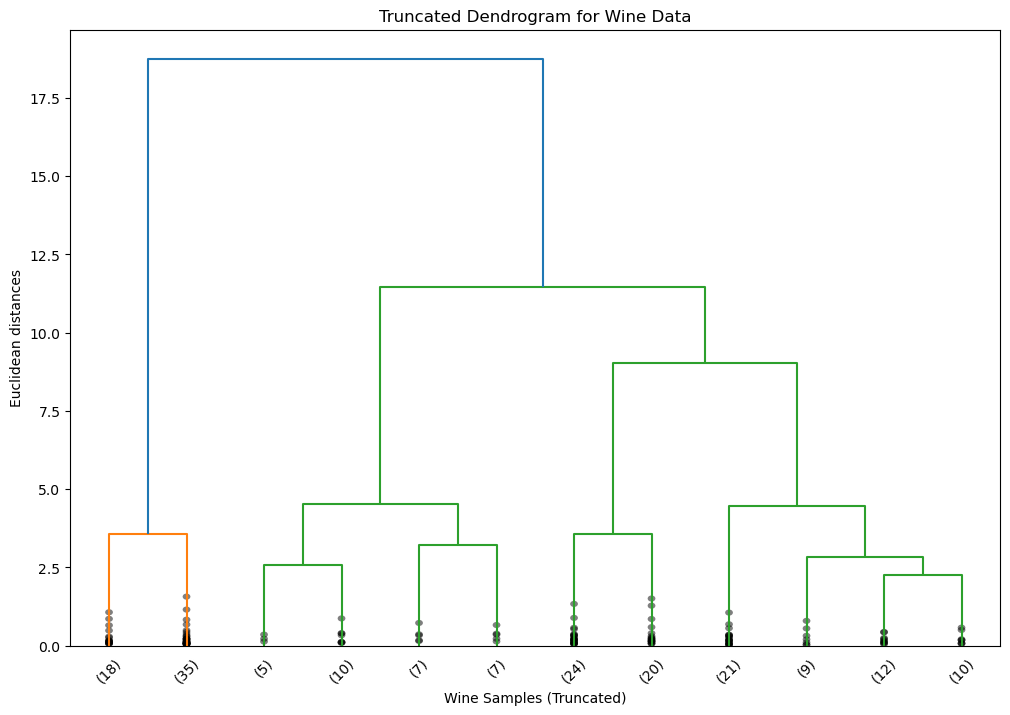

In [283]:
# Step 4: Generate the linkage matrix using the 'ward' method
Z = linkage(X_scaled, method='ward')

# Step 5: Plot the dendrogram with improvements
plt.figure(figsize=(12, 8))  # Increase the figure size for better readability

# Truncate the dendrogram to show only the last 12 merged clusters
dendrogram(
    Z,
    truncate_mode='lastp',  # Show only the last p merged clusters
    p=12,  # Adjust p to show more or fewer clusters
    leaf_rotation=45,  # Rotate x-axis labels for better readability
    leaf_font_size=10,  # Increase font size for readability
    show_contracted=True  # Show shortened version of leaf nodes
)

plt.title('Truncated Dendrogram for Wine Data')
plt.xlabel('Wine Samples (Truncated)')
plt.ylabel('Euclidean distances')
plt.show()

Dynamically calculated max_distance: 11.447875029715593
Dynamically determined number of clusters: 2


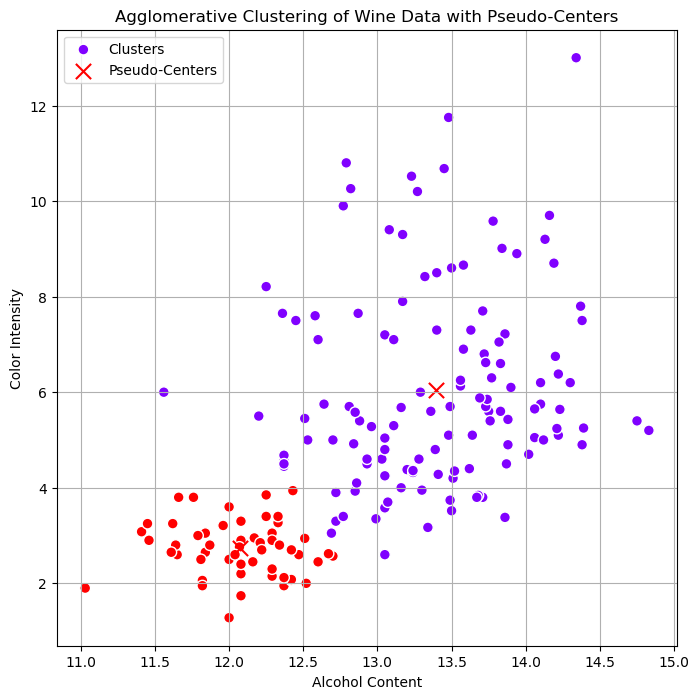

In [243]:
# Step 4: Generate the linkage matrix using the 'ward' method
Z = linkage(X_scaled, method='ward')

# Step 5: Dynamically calculate the max_distance based on the largest gap between successive merges
distances = Z[:, 2]
gaps = np.diff(distances)
max_gap_index = np.argmax(gaps)
max_distance = distances[max_gap_index]
print(f"Dynamically calculated max_distance: {max_distance}")

# Step 6: Use fcluster to dynamically find the number of clusters based on the max_distance
clusters = fcluster(Z, t=max_distance, criterion='distance')

# Step 7: Determine the number of unique clusters
n_clusters = len(np.unique(clusters))
print(f"Dynamically determined number of clusters: {n_clusters}")

# Step 8: Apply Agglomerative Clustering using the dynamically determined number of clusters
agg_model = AgglomerativeClustering(n_clusters=n_clusters)
Y_agg = agg_model.fit_predict(X_scaled)

# Step 9: Calculate pseudo-centers for each cluster by averaging the points in each cluster
pseudo_centers = []
for cluster_label in np.unique(Y_agg):
    cluster_points = X_scaled[Y_agg == cluster_label]
    cluster_center = np.mean(cluster_points, axis=0)  # Calculate the mean (pseudo-center)
    pseudo_centers.append(cluster_center)

pseudo_centers = np.array(pseudo_centers)

# Step 10: Visualize the Agglomerative Clustering Results with pseudo-centers
plt.figure(figsize=(8, 8))
plt.scatter(X_wine[:, 0], X_wine[:, 1], c=Y_agg, cmap='rainbow', marker='o', s=60, edgecolors='w', label='Clusters')

# Plotting the pseudo-centers (converting them back to original scale)
pseudo_centers_original = scaler.inverse_transform(pseudo_centers)
plt.scatter(pseudo_centers_original[:, 0], pseudo_centers_original[:, 1], s=120, c='red', marker='x', label='Pseudo-Centers')

plt.title('Agglomerative Clustering of Wine Data with Pseudo-Centers')
plt.xlabel('Alcohol Content')
plt.ylabel('Color Intensity')
plt.legend()
plt.grid(True)
plt.show()

**Quality Of Clustering_Dendrogram**

In [287]:
# Step 12: Calculate the V-measure score between predicted cluster labels and true labels
v_measure = v_measure_score(y_true, Y_agg)
print(f'\nV-measure score: {v_measure:.4f}')  # Higher values mean better clustering quality


V-measure score: 0.4129


### ***3. Mean-Shift***

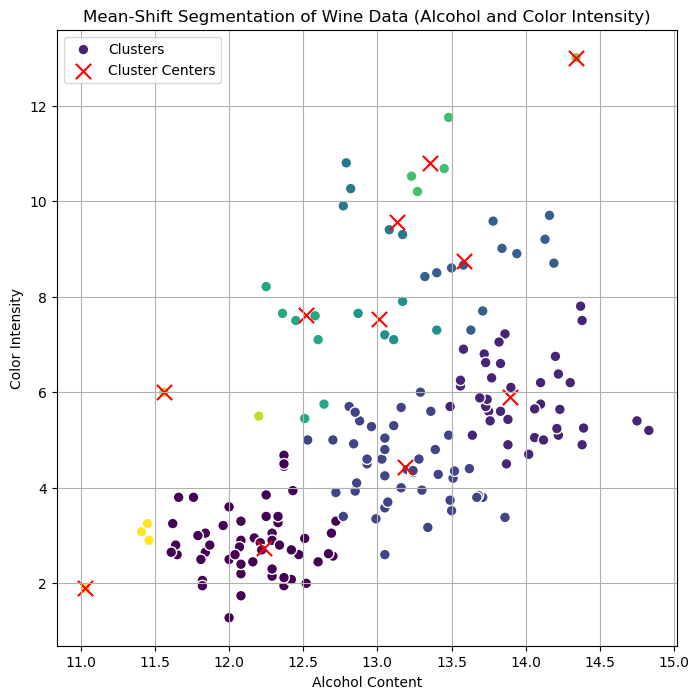

In [307]:
# Step 4: Estimate the bandwidth for Mean-Shift clustering
bandwidth = estimate_bandwidth(X_scaled, quantile=0.1, n_samples=200)  # Adjust quantile if needed

# Step 5: Apply Mean-Shift clustering with the estimated bandwidth
meanshift = MeanShift(bandwidth=bandwidth)
cluster_labels = meanshift.fit_predict(X_scaled)  # Predicted cluster labels

# Step 6: Add cluster labels to the dataframe for comparison with 'Target'
df_wine['cluster_labels'] = cluster_labels

# Step 7: Plotting the Mean-Shift clustering results with alcohol and color_intensity
plt.figure(figsize=(8, 8))

# Plot the data points with cluster labels (alcohol and color_intensity)
plt.scatter(X_wine['alcohol'], X_wine['color_intensity'], c=cluster_labels, cmap='viridis', marker='o', s=60, edgecolors='w', label='Clusters')

# Plot the cluster centers
unique_centers = scaler.inverse_transform(meanshift.cluster_centers_)  # Inverse transform to get the original scale
plt.scatter(unique_centers[:, 0], unique_centers[:, 1], s=120, c='red', marker='x', label='Cluster Centers')

# Add title and labels
plt.title('Mean-Shift Segmentation of Wine Data (Alcohol and Color Intensity)')
plt.xlabel('Alcohol Content')
plt.ylabel('Color Intensity')
plt.legend()
plt.grid(True)
plt.show()


**Quality Of Clustering_Mean-Shift**

In [309]:
# Optional: Crosstab to compare predicted clusters with actual labels (Target)
if 'Target' in df_wine.columns:
    # Calculate the V-measure score between predicted cluster labels and true labels
    y_true = df_wine['Target'].values
    v_measure = v_measure_score(y_true, cluster_labels)
    print(f'\nV-measure score: {v_measure:.4f}')  # Higher values mean better clustering quality


V-measure score: 0.4478


## **Accuracy By Comparing Actual Label And Cluster Label**

In [262]:
# Create a crosstab to compare clusters with actual labels K-Means
ct = pd.crosstab(df['cluster_labels'], df['Target'])

# Display the crosstab
print(ct)

Target           0   1   2
cluster_labels            
0               51   8  14
1                1  63   6
2                7   0  28


Cluster 0: Majority of the samples are from Target 0 (51 samples).
Cluster 1: Majority of the samples are from Target 1 (63 samples).
Cluster 2: Majority of the samples are from Target 2 (28 samples). 
While this shows a fairly good grouping, there is still some overlap in clusters. For instance, cluster 0 has 8 samples from Target 1 and 14 from Target 2.

In [267]:
# Step 11: Crosstab to compare predicted clusters with actual labels Dendrogram
df_wine['cluster_labels'] = Y_agg  # Add cluster labels to the dataframe
ct = pd.crosstab(df_wine['cluster_labels'], df_wine['Target'])
print("Crosstab comparing predicted clusters and actual labels:")
print(ct)

Crosstab comparing predicted clusters and actual labels:
Target           0   1   2
cluster_labels            
0               59  19  47
1                0  52   1


Cluster 0: A wide mixture from Target 0, Target 1, and Target 2 (more overlap).
Cluster 1: Almost entirely Target 1 with little overlap.
The dendrogram shows more significant overlap, especially in cluster 0, where many samples from different target groups are mixed.

In [301]:
# Step 11: Crosstab to compare predicted clusters with actual labels Mean-Shift
if 'Target' in df_wine.columns:
    # Crosstab to compare predicted clusters with actual labels (Target)
    ct = pd.crosstab(df_wine['cluster_labels'], df_wine['Target'])
    print("Crosstab comparing predicted clusters and actual labels:")
    print(ct)

Crosstab comparing predicted clusters and actual labels:
Target           0   1   2
cluster_labels            
0                0  54   1
1               35   0   4
2               20  11  13
3                3   0   9
4                0   0   5
5                1   0   4
6                0   1   6
7                0   0   4
8                0   0   1
9                0   1   1
10               0   4   0


This clustering creates many smaller clusters with a significant spread of different target values across multiple clusters. There is a large amount of overlap between the clusters and the targets, making this clustering less ideal.

K-Means: This model provides the most distinct separation between the clusters and their corresponding target labels. Despite some overlap, the majority of the clusters are dominated by one target class, indicating better performance compared to the other models.
K-Means is providing the most accurate clustering output based on the crosstabs, as it has clearer groupings with a majority of the samples belonging to distinct target classes.

### **STORE THE MODEL IN JOBLIB**

In [211]:
# Save the model using joblib
dump(kmeans, 'kmeans_wine_clustering.joblib')

['kmeans_wine_clustering.joblib']

### **LOAD THE MODEL AND OUTPUT**

In [338]:
# Suppress the KMeans warning for memory leaks on Windows with MKL
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

# Assume the KMeans model and scaler have already been trained using the full dataset
scaler = StandardScaler()
kmeans = KMeans(n_clusters=3, random_state=42)

# Simulated training data and scaling (replace this with your actual dataset)
X_train = np.array([[14, 5], 
                    [13, 6], 
                    [12, 4]])  # Example data with only alcohol and color_intensity
scaler.fit(X_train)
kmeans.fit(scaler.transform(X_train))

# Define more meaningful names for each cluster
cluster_descriptions = {
    0: "You are Casual Drinker" 
    "You seem to enjoy light, refreshing wines with bold color and acidity. You’re likely a casual drinker who prefers wines that are crisp and lively",
    1: "You are Experienced Drinker"
    "You have the refined palate of a connoisseur! You enjoy balanced, flavorful, and structured wines with higher alcohol content. A fine wine experience is definitely your preference.",
    2: "You are health-conscious individuals or occasional drinkers."
    "Your wine choice likely leans towards something subtle and easy-going."
}

# Function to take user input and predict the cluster based on only alcohol and color intensity
def predict_wine_cluster():
    print("Please share your wine preferences with us. Let's discover how fine your wine-tasting skills really are!")

    try:
        # Get user input for only alcohol content and color intensity
        alcohol_content = float(input("Enter the alcohol content (typical range: 11-15): "))
        color_intensity = float(input("Enter the color intensity (typical range: 1-13): "))

        # Combine inputs into a single array for prediction
        user_input = np.array([[alcohol_content, color_intensity]])

        # Scale the user input using the previously trained scaler
        user_input_scaled = scaler.transform(user_input)

        # Predict the cluster and map it to a description
        cluster_label = kmeans.predict(user_input_scaled)[0]
        cluster_name = cluster_descriptions[cluster_label]

        print(f"\n**{cluster_name}**.")

    except ValueError as e:
        # Handle any value errors from invalid inputs
        print(f"Error: {e}. Please enter valid numeric values.")

    except Exception as e:
        # Catch any other unexpected errors
        print(f"An unexpected error occurred: {e}")

# Run the function to allow user input and predict
predict_wine_cluster()

Please share your wine preferences with us. Let's discover how fine your wine-tasting skills really are!


Enter the alcohol content (typical range: 11-15):  15
Enter the color intensity (typical range: 1-13):  13



**You are Casual DrinkerYou seem to enjoy light, refreshing wines with bold color and acidity. You’re likely a casual drinker who prefers wines that are crisp and lively**.
